<a href="https://colab.research.google.com/github/DikshyaL/Student-Anomaly-Detection/blob/main/Anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kayhanh/student-performance-1-million")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'student-performance-1-million' dataset.
Path to dataset files: /kaggle/input/student-performance-1-million


In [45]:
import os
os.listdir("/root/.cache/kagglehub/datasets/kayhanh/student-performance-1-million/versions/1")

['student_performance.csv']

In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("/root/.cache/kagglehub/datasets/kayhanh/student-performance-1-million/versions/1/student_performance.csv")
df.head()


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score,grade
0,1,18.5,95.6,3.8,97.9,A
1,2,14.0,80.0,2.5,83.9,B
2,3,19.5,86.3,5.3,100.0,A
3,4,25.7,70.2,7.0,100.0,A
4,5,13.4,81.9,6.9,92.0,A


In [47]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   student_id               1000000 non-null  int64  
 1   weekly_self_study_hours  1000000 non-null  float64
 2   attendance_percentage    1000000 non-null  float64
 3   class_participation      1000000 non-null  float64
 4   total_score              1000000 non-null  float64
 5   grade                    1000000 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 45.8+ MB


In [48]:
df.describe()


,student_id,weekly_self_study_hours,attendance_percentage,class_participation,total_score
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,500000.500000,15.029127,84.711046,5.985203,84.283845
std,288675.278933,6.899431,9.424143,1.956421,15.432969
min,1.000000,0.000000,50.000000,0.000000,9.400000
25%,250000.750000,10.300000,78.300000,4.700000,73.900000
50%,500000.500000,15.000000,85.000000,6.000000,87.500000
75%,750000.250000,19.700000,91.800000,7.300000,100.000000
max,1000000.000000,40.000000,100.000000,10.000000,100.000000


In [49]:
df.size


6000000

In [50]:
df.columns

Index(['student_id', 'weekly_self_study_hours', 'attendance_percentage',
       'class_participation', 'total_score', 'grade'],
      dtype='object')

In [51]:
X = df.select_dtypes(include=[np.number])
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

print("Data shape after scaling/ preprocessing:", X_scaled.shape)


Data shape after scaling/ preprocessing: (1000000, 5)


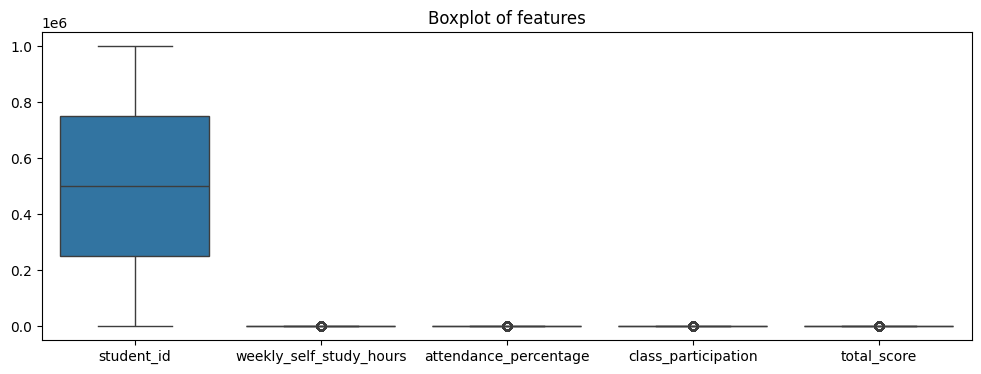

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,4))
sns.boxplot(data = X)
plt.title("Boxplot of features")
plt.show()

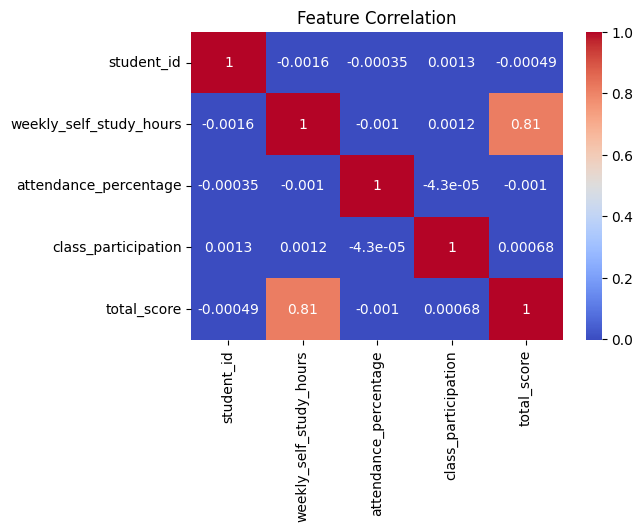

In [53]:
plt.figure(figsize=(6,4))
sns.heatmap(X.corr(), annot=True, cmap ="coolwarm")
plt.title("Feature Correlation")
plt.show()

In [54]:
#Z- Score Method
from scipy.stats import zscore

z_scores = np.abs(zscore(X_scaled))
anomalies_z = (z_scores>3).any(axis=1)

df["anomaly_zscore"] = anomalies_z

print("Anamolies deteccted (Z-score):", anomalies_z.sum())

Anamolies deteccted (Z-score): 9414


In [55]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

iso.fit(X_scaled)
df["anomaly_iforest"] =iso.predict(X_scaled)

# Convert labels: -1 → anomaly, 1 → normal
df["anomaly_iforest"] = df["anomaly_iforest"].map({1:0, -1:1})

print("Anomalies detected (Isolation Forest):",
      df["anomaly_iforest"].sum())

Anomalies detected (Isolation Forest): 50000


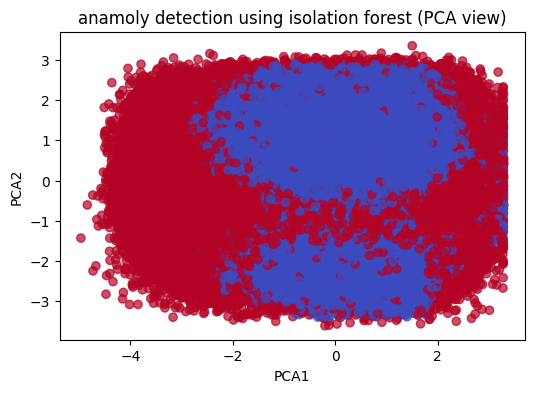

In [56]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,4))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=df["anomaly_iforest"],
            cmap="coolwarm" , alpha = 0.7)
plt.title("anamoly detection using isolation forest (PCA view)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

# Adding one-class SVM and LOF
one class svm= a support vector machine trained only on normal data that
learns a decision boundary around normal behaviour
-learn where most data live
anything outside = anamoly

where as

LOF (local outlier factor) = a density basaed anomlay detection algorithm
-normal live in dense neighbourhood
-Anomalies live in sparse region


In [57]:
np.random.seed(42)

sample_size = 50000  # 50k is safe and fast
sample_idx = np.random.choice(len(X_scaled), sample_size, replace=False)

X_sample = X_scaled[sample_idx]


from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(
    kernel = "rbf",
    gamma = "scale",
    nu= 0.05  # expected fraction of anomalies
)

ocsvm_preds =ocsvm.fit_predict(X_sample)

df["anomaly_ocsvm"] = pd.Series(ocsvm_preds).map({1:0, -1:1})

print("Anomalies detected (OCSVM):", df["anomaly_ocsvm"].sum())

Anomalies detected (OCSVM): 2507.0


In [58]:
from sklearn.neighbors import LocalOutlierFactor
import pandas as pd

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.05
)

lof_preds = lof.fit_predict(X_scaled)

df["anomaly_lof"] = pd.Series(lof_preds).map({1: 0, -1: 1})

print("Anomalies detected (LOF):", df["anomaly_lof"].sum())


Anomalies detected (LOF): 50000


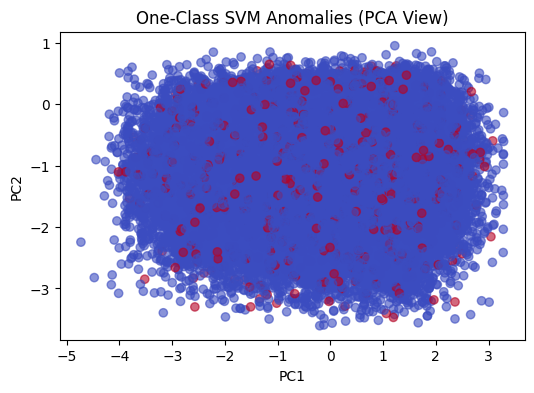

In [59]:
plt.figure(figsize=(6,4))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df["anomaly_ocsvm"],
    cmap="coolwarm",
    alpha=0.6
)
plt.title("One-Class SVM Anomalies (PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


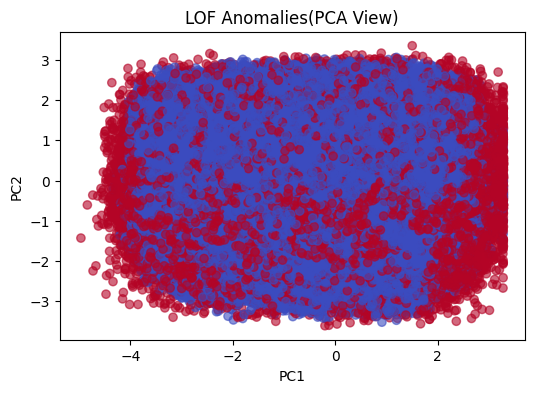

In [60]:
plt.figure(figsize=(6,4))
plt.scatter(
    X_pca[:,0],
    X_pca[:,1],
    c=df["anomaly_lof"],
    cmap="coolwarm",
    alpha=0.6
)
plt.title("LOF Anomalies(PCA View)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
